## Plots from the Paper

In [1]:
import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = 14.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['font.sans-serif'] = "Arial"

cm = 1/2.54  # centimeters in inches

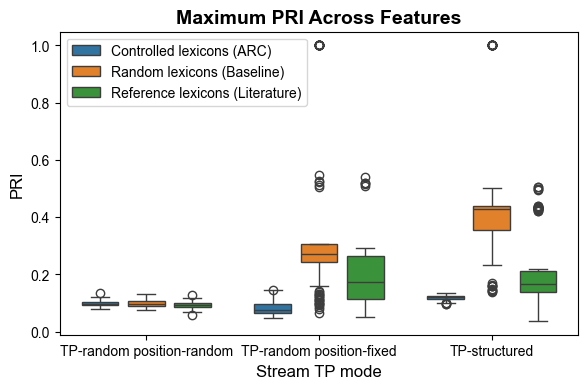

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tp_modes_pretty = ["TP-random position-random", "TP-random position-fixed", "TP-structured"]

df = pd.read_csv("data_submission/full_dataset.csv")

_, ax = plt.subplots(figsize=(17*cm, 10*cm))
sns.boxplot(df[df["Feature"] == "max"], x="Stream TP mode", y="PRI", hue="Control", order=tp_modes_pretty, gap=0.2)
plt.title("Maximum PRI Across Features")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

plt.savefig("results/lexicon_pris_summary.pdf", dpi=600)

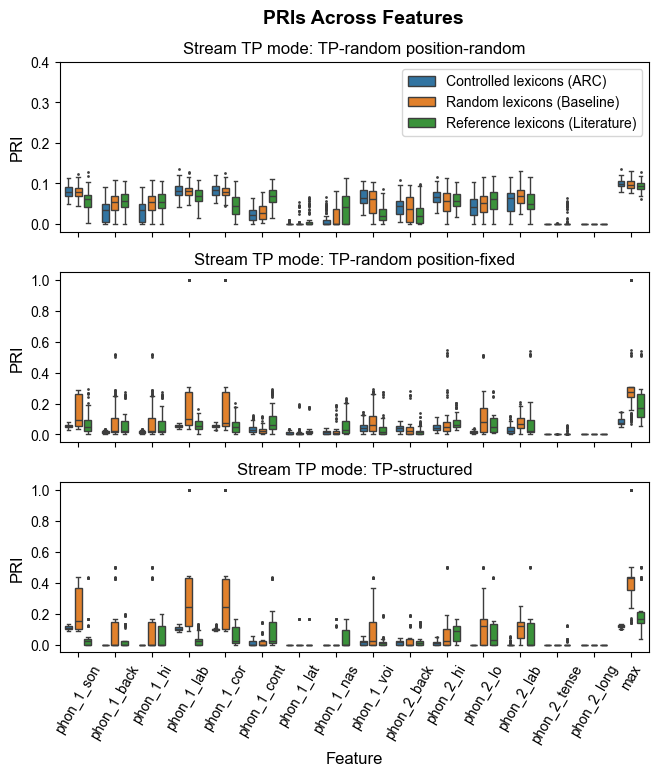

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1, figsize=(17*cm, 20*cm), layout="tight", sharex=True)
labels = ['Controlled\nlexicons (ARC)',
 'Reference\nlexicons (Literature)',
 'Random\nlexicons (Baseline)']

for i, tp_mode in enumerate(tp_modes_pretty):
    sns.boxplot(df[df["Stream TP mode"] == tp_mode], x="Feature", y="PRI", hue="Control", ax=axs[i], fliersize=1, gap=0.3)
    axs[i].set_title(f"Stream TP mode: {tp_mode}", weight="normal", size=12)
    if i == 0:
        axs[i].set(ylim=(-0.02, 0.4))
        # axs[i].legend(labels)
        # sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
        sns.move_legend(axs[i], "upper left")
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles=handles, labels=labels)
        
    else:
        axs[i].legend([],[], frameon=False)
locs, labls = plt.xticks()
plt.xticks(locs, labls, rotation=60)
plt.suptitle(f"PRIs Across Features", weight="bold", size=14, x=0.55)
plt.savefig("results/lexicon_pri.pdf", dpi=600)

## Visualization of Feature Overlap

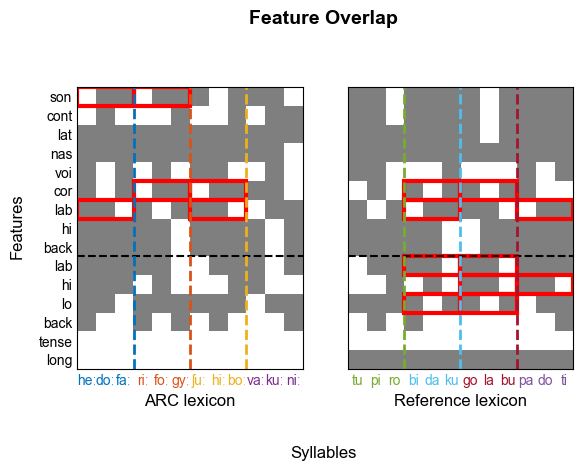

In [13]:
import csv 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

# GLOBAL PARAMETERS
nSyll = 12
nTrip = 4
nPoss = 3
nReps = nTrip * 15

# IMPORT MATRIX OF BINARY FEATURES FOR ALL IPA PHONEMES
indir = 'arc/data/'
fname = indir + 'phonemes.csv'
fdata = list(csv.reader(open(fname, "r")))
labls = fdata[0][1:]
lbl_C = ['son', 'back', 'hi', 'lab', 'cor', 'cont', 'lat', 'nas', 'voi']
lbl_V = ['back', 'hi', 'lo', 'lab', 'tense', 'long']
phons = [i[0] for i in fdata[1:]]
numbs = [i[1:] for i in fdata[1:]]
nFeat = len(lbl_C) + len(lbl_V)

# IMPORT STREAMS FROM TITONE, MILOSEVIC & MEYER (2024) ARC PACKAGE
indir = 'data_submission/'
fname = indir + 'best_lexicon.txt'
fdata = list(csv.reader(open(fname, "r")))
lexicon_words = fdata[0][0].split(": ")[1].split("|")
lexicon_sylls = [list(map(''.join, zip(*[iter(i)]*nPoss))) for i in lexicon_words]
TP_posrdm_arc = fdata[2][0].split(": ")[1].split("|")
TP_struct_arc = fdata[7][0].split(": ")[1].split("|")
TP_posfix_arc = fdata[12][0].split(": ")[1].split("|")
TP_stream_arc = [TP_struct_arc, TP_posfix_arc, TP_posrdm_arc]
TP_fnames_arc = ['TP_struct_ARC', 'TP_posfix_ARC', 'TP_posrdm_ARC']

# IMPORT ONE REFERENCE LEXICON
lexicon_reference = [['tu', 'pi', 'ro'],
                     ['bi', 'da', 'ku'],
                     ['ɡo', 'la', 'bu'],
                     ['pa', 'do', 'ti']]
Lexicons = [lexicon_sylls, lexicon_reference]

# COMPUTE FEATURE MATRIX FOR EACH SYLLABLE IN THE LEXICON
Feats_by_sylls_by_words = []
Feats_by_sylls = []
for iLexi in Lexicons:
    feats_by_sylls_by_words = []
    feats_by_sylls = []
    for iWord in range(nTrip):
        V = []
        for iSyll in range(len(iLexi[iWord])):
            sylli = iLexi[iWord][iSyll]
            iCons = sylli[0]
            iVows = sylli[1:]
            fCons = numbs[phons.index(iCons)]
            fVows = numbs[phons.index(iVows)]
            nFeat = [i for i in range(len(labls)) if labls[i] in lbl_C]
            v = []
            for iFeat in nFeat:
                if fCons[iFeat] == '+':
                    v.append(1)
                else:
                    v.append(0)
            nFeat = [i for i in range(len(labls)) if labls[i] in lbl_V]
            for iFeat in nFeat:
                if fVows[iFeat] == '+':
                    v.append(1)
                else:
                    v.append(0)
            V.append(v)
            feats_by_sylls.append(v)
        feats_by_sylls_by_words.append(np.transpose(np.matrix(V)))
    Feats_by_sylls_by_words.append(feats_by_sylls_by_words)
    Feats_by_sylls.append(feats_by_sylls)

# EXTRACT FEATURE OVERLAP FOR WORDS IN THE LEXICON
patts = [tuple([i for i in np.roll((1, 0, 0), j)]) for j in range(nPoss)]
nFeat = len(lbl_C) + len(lbl_V)
BB = []
for iLexi in range(len(Lexicons)):
    B = []
    for iFeat in range(nFeat):
        F = []
        for iWord in range(nTrip):
            F.append(Feats_by_sylls_by_words[iLexi][iWord][iFeat])
        F = [tuple(i.tolist()[0]) for i in F]
        D = dict((j, [i for i, k in enumerate(F) if k == j]) for j in set(F) if F.count(j) > 1)
        I = set()
        for key, val in D.items():
            if key in patts:
                for i in val:
                    I.add(i)
        if any(I):
            B.append((iFeat, [i for i in I]))
    BB.append(B)

# FIGURE REPRESENTING BINARY FEATURE MATRIX FOR THE LEXICON WORDS (LAG = 3)
L = [labls[i] for i in range(len(labls)) if labls[i] in lbl_C]
L.extend([labls[i] for i in range(len(labls)) if labls[i] in lbl_V])
C_a = [(0.0000, 0.4470, 0.7410), 
       (0.8500, 0.3250, 0.0980), 
       (0.9290, 0.6940, 0.1250), 
       (0.4940, 0.1840, 0.5560)]
C_b = [(0.4660, 0.6740, 0.1880),
       (0.3010, 0.7450, 0.9330),
       (0.6350, 0.0780, 0.1840),
       (0.4940, 0.3294, 0.6196)]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
for iLexi in range(len(Lexicons)):
    V = np.transpose(np.matrix(Feats_by_sylls[iLexi]))
    G = np.zeros((V.shape[0],V.shape[1],3))
    G[V == 1] = [1.0,1.0,1.0]
    G[V == 0] = [0.5,0.5,0.5]
    if iLexi == 0:
        ax1.imshow(G, interpolation = 'nearest')
    else:
        ax2.imshow(G, interpolation = 'nearest')
    for b in BB[iLexi]:
        y_pos = b[0] - 0.5
        y_width = 1
        for l in b[1]:
            x_pos = l*nPoss - 0.5
            x_width = nPoss
            r = patches.Rectangle((x_pos, y_pos), x_width, y_width,
                                  linewidth = 3, edgecolor = 'r', facecolor = 'none')
            if iLexi == 0:
                ax1.add_patch(r)
            else:
                ax2.add_patch(r)
fig.supxlabel('Syllables', x = 0.51, fontsize = 12, fontname = 'Arial')
fig.supylabel('Features', fontsize = 12, fontname = 'Arial')
fig.suptitle('Feature Overlap', x = 0.51, y = 0.95, 
             fontsize = 14, fontweight = 'bold', fontname = 'Arial')
ax1.axhline(len(lbl_C) - 0.5, linestyle = '--', color = 'black')
ax2.axhline(len(lbl_C) - 0.5, linestyle = '--', color = 'black')
ax1.set_xlabel('ARC lexicon', fontsize = 12, fontname = 'Arial')
ax2.set_xlabel('Reference lexicon', fontsize = 12, fontname = 'Arial')
ax1.set_xticks(range(nSyll), [i for j in Lexicons[0] for i in j])
ax2.set_xticks(range(nSyll), [i for j in Lexicons[1] for i in j])
ax1.set_yticks(range(len(L)), L, fontname = 'Arial')
ax1.tick_params(length = 0)
ax2.tick_params(length = 0)
for i in range(nPoss):
    ax1.axvline(nPoss*(i+1)-0.5, linewidth = 2, linestyle = '--', color = C_a[i])
    ax2.axvline(nPoss*(i+1)-0.5, linewidth = 2, linestyle = '--', color = C_b[i])
for i in range(nTrip):
    for j in range(nPoss):
        ax1.get_xticklabels()[i*nPoss+j].set_color(C_a[i])
        ax2.get_xticklabels()[i*nPoss+j].set_color(C_b[i])
opdir = 'results/'
f_out = opdir + 'feature_overlap.pdf'
plt.show()
fig.savefig(f_out, bbox_inches = 'tight', dpi = 600)

# %%

In [35]:
for i, lex in enumerate(controlled_lexicons):
    print(i, lex)

0 hiːtoːfuː|kuːfaːnɛː|biːhuːzyː|roːfiːkɛː
1 hiːtoːfuː|roːfaːkøː|biːhuːzyː|fiːtyːhoː
2 kaːzuːmyː|foːheːtɛː|nuːkɛːfaː|ʃoːbiːhuː
3 hoːdeːvaː|kaːfiːluː|biːhuːzyː|loːfaːkøː
4 kaːzuːmyː|ruːkoːfyː|biːhuːzyː|heːvaːtuː
5 fiːtoːhuː|foːheːtɛː|reːfyːɡiː|hoːzyːbuː
6 ʃeːhoːbiː|kaːzuːmyː|reːvaːkoː|fyːhiːtɛː
7 hiːtoːfuː|kɛːfiːraː|vaːroːɡɛː|ʃuːɡiːmyː
8 kaːzuːmyː|heːbiːʃøː|ruːkoːfyː|fuːroːɡɛː
9 byːhoːzɛː|kaːfiːluː|riːfyːkoː|huːzyːpeː
10 nyːfuːɡaː|biːhuːzyː|køːnuːfoː|vaːtoːheː
11 zuːheːpiː|fiːnuːkaː|ɡiːfaːryː|huːʃoːbyː
12 hiːtoːfuː|fyːkoːnɛː|nyːfoːkuː|ʃøːheːpiː
13 hiːtoːfuː|kuːfaːnɛː|raːfiːkɛː|biːhuːzyː
14 byːhoːzɛː|ɡaːreːfyː|poːʃuːhiː|nyːfoːkuː
15 zuːheːpiː|kaːfoːreː|nyːfuːɡaː|fiːtoːhuː
16 hoːdeːvaː|kaːfiːluː|ruːfaːkoː|biːhuːzyː
17 kaːzuːmyː|riːɡaːfuː|heːbiːʃøː|beːhoːʃiː
18 riːɡaːfuː|biːhuːzyː|ʃiːbøːheː|ɡiːlyːfaː
19 riːkaːfoː|biːhuːzyː|fuːtoːhiː|ʃaːmyːkoː
20 heːfaːtɛː|hiːtoːfuː|ʃiːbeːhoː|biːhuːʃoː


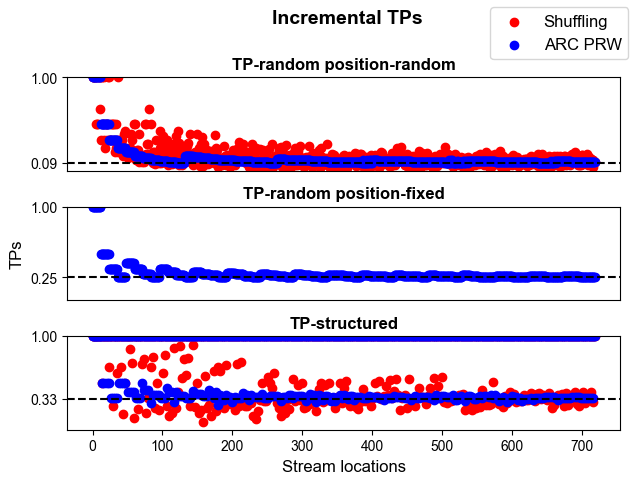

In [15]:
#%%#################################################################################################
############################### TRANSITIONAL PROBABILITY: STATISTICS (Figure 5) ###############################
####################################################################################################
from scipy import stats
import pickle
    
# LOAD INCREMENTAL TP MATRIX FOR ALL STREAMS
indir = 'data_submission/'
fname = indir + 'Incremental_TPs.pickle'
with open(fname, 'rb') as f:
    fdata = pickle.load(f)
Incremental_TPs = fdata

# PLOT INCREMENTAL TP MATRIX FOR ALL STREAMS
opdir = 'results/'
f_out = opdir + 'stream_TP_statistics.pdf'
groups = [r'Shuffling', r'ARC PRW']
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout = 'tight')
y_ax1 = Incremental_TPs[1][0]
y_ax3 = Incremental_TPs[1][1]
ax1.scatter(range(len(y_ax1)), y_ax1, color = 'r')
ax3.scatter(range(len(y_ax3)), y_ax3, color = 'r')
y_ax1 = Incremental_TPs[0][2]
y_ax2 = Incremental_TPs[0][1]
y_ax3 = Incremental_TPs[0][0]
ax1.scatter(range(len(y_ax1)), y_ax1, color = 'b')
ax2.scatter(range(len(y_ax2)), y_ax2, color = 'b')
ax3.scatter(range(len(y_ax3)), y_ax3, color = 'b')
ax1.set_title(r'TP-random position-random', fontsize = 12, fontname = 'Arial')
ax2.set_title(r'TP-random position-fixed', fontsize = 12, fontname = 'Arial')
ax3.set_title(r'TP-structured', fontsize = 12, fontname = 'Arial')
ax3.set_xlabel(r'Stream locations', fontsize = 12, fontname = 'Arial')
ax2.set_ylabel(r'TPs', fontsize = 12, fontname = 'Arial')
ax1.axhline(0.09, linestyle = '--', color = 'black')
ax2.axhline(0.25, linestyle = '--', color = 'black')
ax3.axhline(0.33, linestyle = '--', color = 'black')
ax1.set_yticks([0.09, 1])
ax2.set_yticks([0.25, 1])
ax3.set_yticks([0.33, 1])
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_ylim([0, 1])
fig.suptitle('Incremental TPs', x = 0.55, y = 1, 
             fontsize = 14, fontname = 'Arial', fontweight = 'bold')
fig.legend(groups, prop={'family':'Arial', 'size':12})
plt.show()
fig.savefig(f_out, bbox_inches = 'tight', dpi = 600)

# RUN LEVENE TEST TO COMPARE VARIANCE OF TP MATRICES
L_struct = stats.levene(Incremental_TPs[0][0][2::3], Incremental_TPs[1][1][2::3], center = 'mean')
L_random = stats.levene(Incremental_TPs[0][2], Incremental_TPs[1][0], center = 'mean')

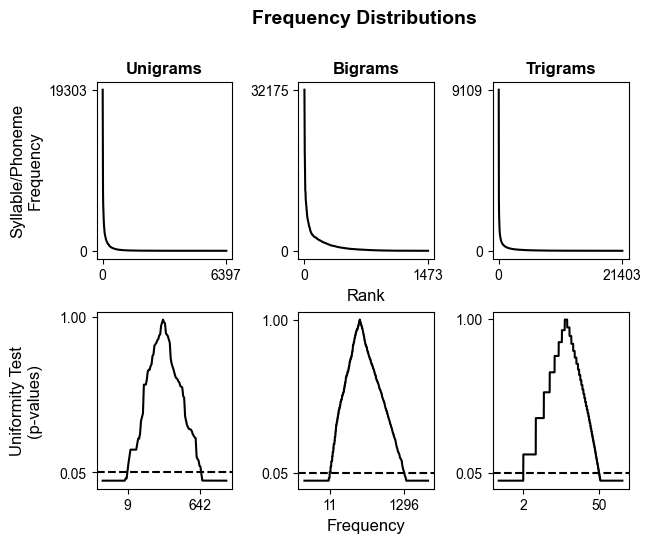

In [19]:
import matplotlib.pyplot as plt
import csv
from arc.phonecodes import phonecodes
from scipy import stats
import numpy as np

# READ SYLLABLES, FREQUENCIES AND PROBABILITIES FROM CORPUS AND CONVERT SYLLABLES TO IPA
indir = 'arc/data/example_corpus/'
fname = indir + 'syll.txt'
fdata = list(csv.reader(open(fname, "r"), delimiter = '\t'))
sylls = [phonecodes.xsampa2ipa(i[1], 'deu') for i in fdata[1:]]
freqs = [int(i[2]) for i in fdata[1:]]
probs = [float(i[3]) for i in fdata[1:]]

# LOAD GERMAN BIGRAMS
indir = 'arc/data/example_corpus/'
fname = indir + 'ipa_bigrams_german.csv'
gram2 = list(csv.reader(open(fname, "r"), delimiter = '\t'))
gram2 = [i[0].split(",") for i in gram2][1:]
freq2 = [int(i[2]) for i in gram2]

# LOAD GERMAN TRIGRAMS
indir = 'arc/data/example_corpus/'
fname = indir + 'ipa_trigrams_german.csv'
gram3 = list(csv.reader(open(fname, "r"), delimiter = '\t'))
gram3 = [i[0].split(",") for i in gram3][1:]
freq3 = [int(i[1]) for i in gram3]

# READ ORDER OF PHONEMES IN GERMAN WORDS
indir = 'arc/data/example_corpus/'
fname = indir + 'german_IPA_seg.csv'
fdata = list(csv.reader(open(fname, "r"), delimiter = '\t'))
fdata = [i[0].split(",") for i in fdata][1:]
fdata = [i for i in fdata if len(i) == 3]
phonX = [i[1].replace('"','') for i in fdata]
phonX = [i.replace("g","ɡ") for i in phonX]
phonP = [int(i[2]) for i in fdata]

# READ MATRIX OF BINARY FEATURES FOR ALL IPA PHONEMES
indir = 'arc/data/'
fname = indir + 'phonemes.csv'
fdata = list(csv.reader(open(fname, "r")))
labls = fdata[0][1:]
phons = [i[0] for i in fdata[1:]]
numbs = [i[1:] for i in fdata[1:]]
cnsnt = [phons[i] for i in range(len(phons)) if numbs[i][labls.index('cons')] == '+']
longV = [phons[i] for i in range(len(phons)) if numbs[i][labls.index('long')] == '+' 
                                             and phons[i] not in cnsnt]

# SELECT CONSONANT-VOWEL SYLLABLES WITH LONG VOWEL LENGTH
cvidx = [i for i in range(len(sylls)) if sylls[i].startswith(tuple(cnsnt))
         and sylls[i].endswith(tuple(longV)) and len(sylls[i]) == 3]
cvsyl = [sylls[i] for i in cvidx]
cvfrq = [freqs[i] for i in cvidx]
cvprb = [probs[i] for i in cvidx]

# SELECT CV SYLLABLES WITH UNIFORM LOG-PROBABILITY OF OCCURRENCE IN THE CORPUS
CVidx = [i for i in range(len(cvfrq)) 
         if stats.uniform.sf(abs(stats.zscore(np.log(cvfrq))))[i] > 0.05 
         and cvsyl[i][0] in phonX]
CVsyl = [cvsyl[i] for i in CVidx]
CVfrq = [cvfrq[i] for i in CVidx]
CVprb = [cvprb[i] for i in CVidx]

# SELECT BIGRAMS WITH UNIFORM LOG-PROBABILITY OF OCCURRENCE IN THE CORPUS
frx_2 = [i for i in range(len(freq2))
          if stats.uniform.sf(abs(stats.zscore(np.log(freq2))))[i] > 0.05]
gram2 = [i[1].replace("_", "") for i in gram2]
gram2 = [i.replace("g","ɡ") for i in gram2]
Gram2 = [gram2[i] for i in frx_2]
Freq2 = [freq2[i] for i in frx_2]

# SELECT TRIGRAMS WITH UNIFORM LOG-PROBABILITY OF OCCURRENCE IN THE CORPUS
frx_3 = [i for i in range(len(freq3))
          if stats.uniform.sf(abs(stats.zscore(np.log(freq3))))[i] > 0.05]
gram3 = [i[0].replace("_", "") for i in gram3]
gram3 = [i.replace("g","ɡ") for i in gram3]
Gram3 = [gram3[i] for i in frx_3]
Freq3 = [freq3[i] for i in frx_3]

# PLOT N-GRAM FREQUENCY DISTRIBUTION OF SYLLABLES AND PHONEMES
opdir = 'results/'
f_out = opdir + 'ngram_frequency_distributions.pdf'
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, layout = "constrained")

# SYLLABLES FREQUENCY DISTRIBUTION
ax1.plot(freqs, color = 'black')
ax1.set_title('Unigrams', fontsize = 12, fontname = 'Arial')
ax1.set_xticks((0, len(freqs)))
ax1.set_yticks((0, freqs[0]))
ax1.set_ylabel('Syllable/Phoneme' + '\n' + 'Frequency', fontsize = 12, fontname = 'Arial')

# BIGRAM FREQUENCY DISTRIBUTION
ax2.plot(freq2, color = 'black')
ax2.set_title('Bigrams', fontsize = 12, fontname = 'Arial')
ax2.set_xticks((0, len(freq2)))
ax2.set_yticks((0, freq2[0]))
ax2.set_xlabel('Rank', fontsize = 12, fontname = 'Arial')

# TRIGRAM FREQUENCY DISTRIBUTION
ax3.plot(freq3, color = 'black')
ax3.set_title('Trigrams', fontsize = 12, fontname = 'Arial')
ax3.set_xticks((0, len(freq3)))
ax3.set_yticks((0, freq3[0]))

# SYLLABLES UNIFORMITY TEST
ax4.plot(stats.uniform.sf(abs(stats.zscore(np.log(cvfrq)))), color = 'black')
ax4.axhline(0.05, linestyle = '--', color = 'black')
ax4.invert_xaxis()
ax4.set_xticks((CVidx[0], CVidx[-1]), (cvfrq[CVidx[0]], cvfrq[CVidx[-1]]))
ax4.set_yticks([0.05, 1.0])
ax4.set_ylabel('Uniformity Test' + '\n' + '(p-values)', fontsize = 12, fontname = 'Arial')

# BIGRAM UNIFORMITY TEST
ax5.plot(stats.uniform.sf(abs(stats.zscore(np.log(freq2)))), color = 'black')
ax5.axhline(0.05, linestyle = '--', color = 'black')
ax5.invert_xaxis()
ax5.set_xticks((frx_2[0], frx_2[-1]), (freq2[frx_2[0]], freq2[frx_2[-1]]))
ax5.set_yticks([0.05, 1.0])
ax5.set_xlabel('Frequency', fontsize = 12, fontname = 'Arial')

# TRIGRAM UNIFORMITY TEST
ax6.plot(stats.uniform.sf(abs(stats.zscore(np.log(freq3)))), color = 'black')
ax6.axhline(0.05, linestyle = '--', color = 'black')
ax6.invert_xaxis()
ax6.set_xticks((frx_3[0], frx_3[-1]), (freq3[frx_3[0]], freq3[frx_3[-1]]))
ax6.set_yticks([0.05, 1.0])

# ADJUST AND SAVE
fig.suptitle('Frequency Distributions', x = 0.56, y = 1.1, 
             fontsize = 14, fontname = 'Arial', fontweight = 'bold')
fig.align_ylabels((ax1, ax4))
plt.show()
fig.savefig(f_out, bbox_inches = 'tight', dpi = 600)